<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv('/datasets/taxi.csv',
                 parse_dates=['datetime'],
                 index_col=['datetime'])

In [3]:
df.sample(10)

,num_orders
datetime,
2018-04-10 20:20:00,7
2018-05-25 08:50:00,13
2018-06-26 21:10:00,14
2018-04-12 21:10:00,16
2018-08-08 07:50:00,3
2018-08-09 05:40:00,1
2018-05-28 22:10:00,13
2018-06-30 20:00:00,16
2018-06-27 23:20:00,17


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.isna().sum()

num_orders    0
dtype: int64

**=>** Данные без пропусков и дубликатов. Прекрасно!

In [6]:
plt.rcParams["figure.figsize"] = (12, 8)

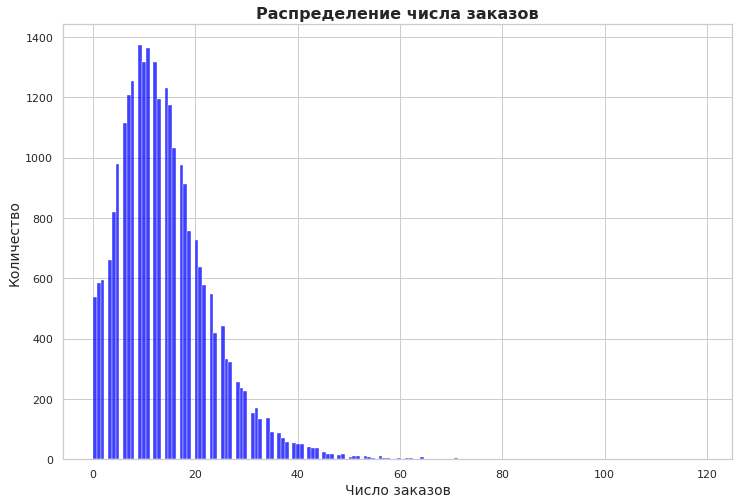

In [7]:
sns.set(style='whitegrid')
sns.histplot(df.num_orders, color='blue')

plt.xlabel('Число заказов', fontsize=14)
plt.ylabel('Количество', fontsize=14)
_ = plt.title('Распределение числа заказов', fontsize=16, weight='bold')

Ресемплируем данные с интервалом 1 час:

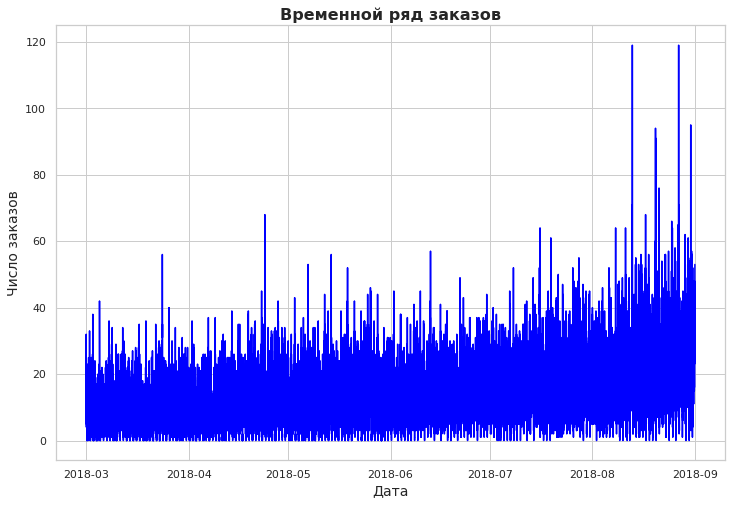

In [8]:
sns.set(style='whitegrid')
sns.lineplot(data=df, x=df.index, y=df.num_orders, color='blue')

plt.xlabel('Дата', fontsize=14)
plt.ylabel('Число заказов', fontsize=14)
_ = plt.title('Временной ряд заказов', fontsize=16, weight='bold')

In [9]:
df = df.resample('1h').sum()

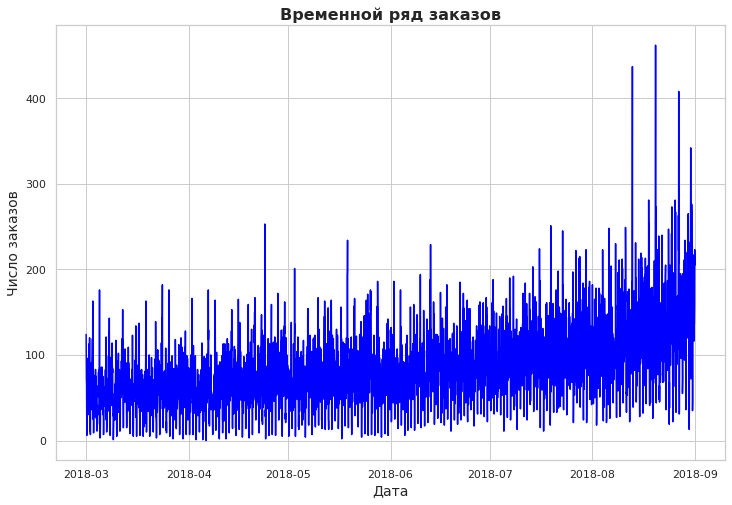

In [10]:
sns.set(style='whitegrid')
sns.lineplot(data=df, x=df.index, y=df.num_orders, color='blue')

plt.xlabel('Дата', fontsize=14)
plt.ylabel('Число заказов', fontsize=14)
_ = plt.title('Временной ряд заказов', fontsize=16, weight='bold')

**Вывод по подготовке**
* Данные загружены, без пропусков
* Проведено ресемплироание данных по одному часу
* Отображены показательные для данных графики

## Анализ

In [11]:
decomposed = seasonal_decompose(df['num_orders'])

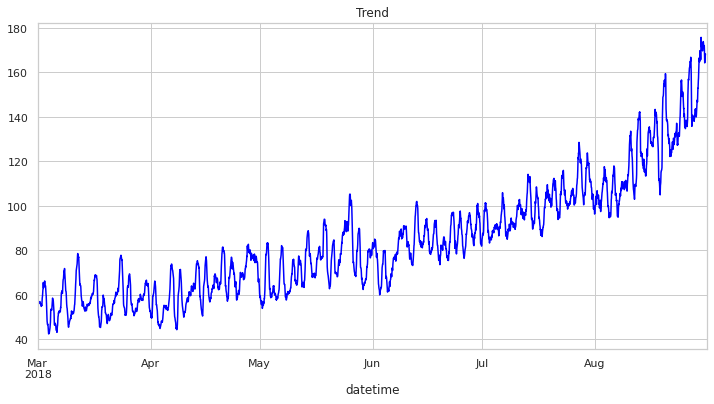

In [12]:
trend = decomposed.trend
trend.plot(figsize=(12,6),ax=plt.gca(), color='blue')
plt.title('Trend')
plt.show()

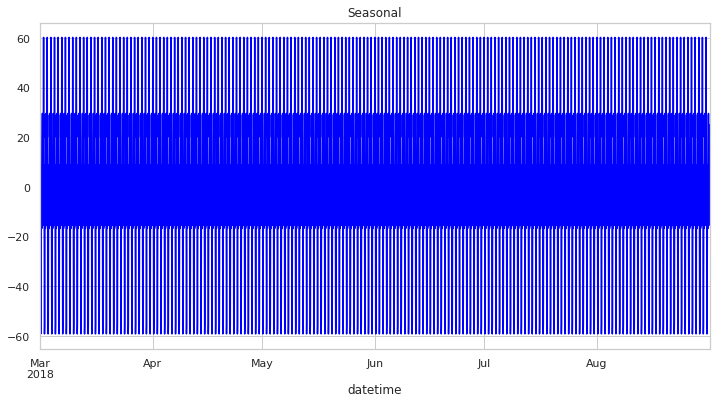

In [13]:
seasonal = decomposed.seasonal
seasonal.plot(figsize=(12,6), ax=plt.gca(), color='blue')
plt.title('Seasonal')
plt.show()

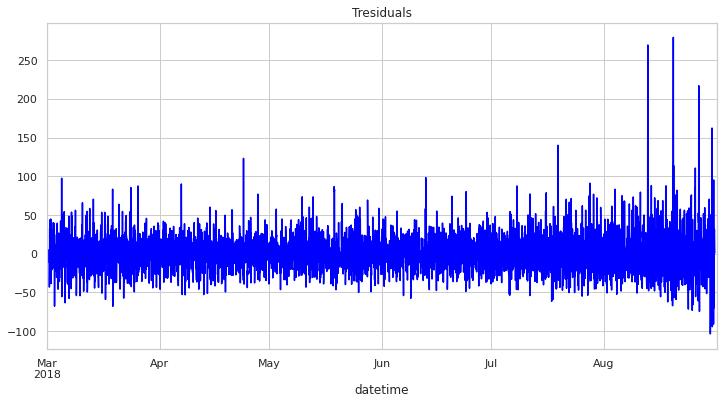

In [14]:
residuals = decomposed.resid
residuals.plot(figsize=(12,6), ax=plt.gca(), color='blue')
plt.title('Tresiduals')
plt.show()

На графике тренда видно увеличение количество заказов такси с каждым месяцом; по остальным графикам ничего конкретного не видно, нужно масштабировать, вибирая временные подотрезки:

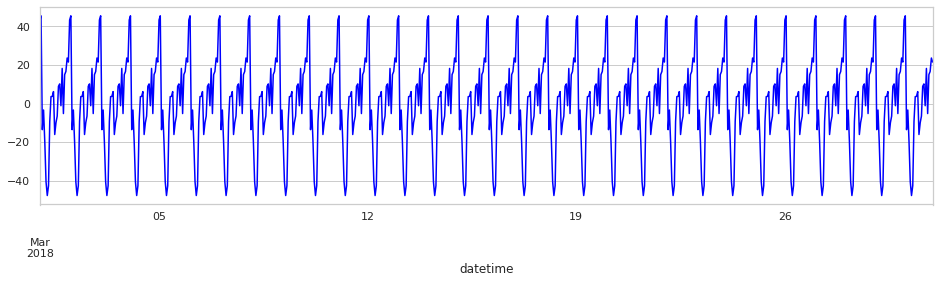

In [15]:
# Сезонность внутри месяца
plt.figure(figsize=(16,8))
decomposed_2month = seasonal_decompose(df['2018-03-01':'2018-03-30'])
plt.title('Сезонность')
plt.subplot(211)
decomposed_2month.seasonal.plot(ax=plt.gca(), color='blue')
plt.show()

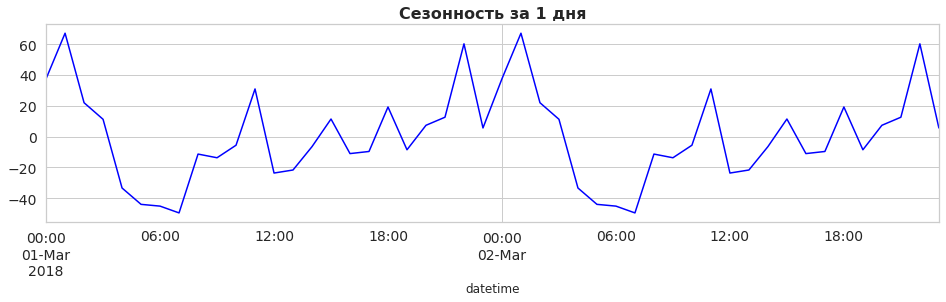

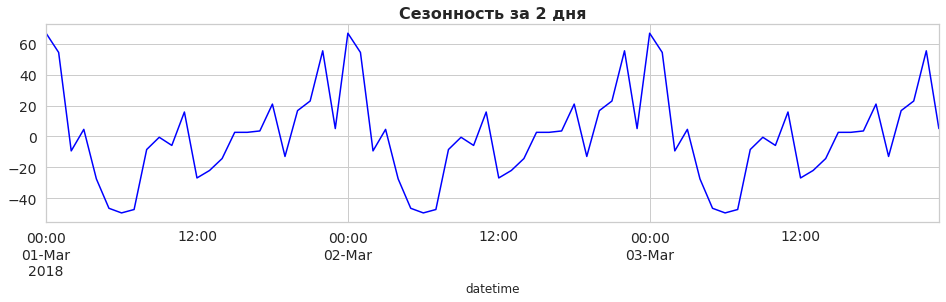

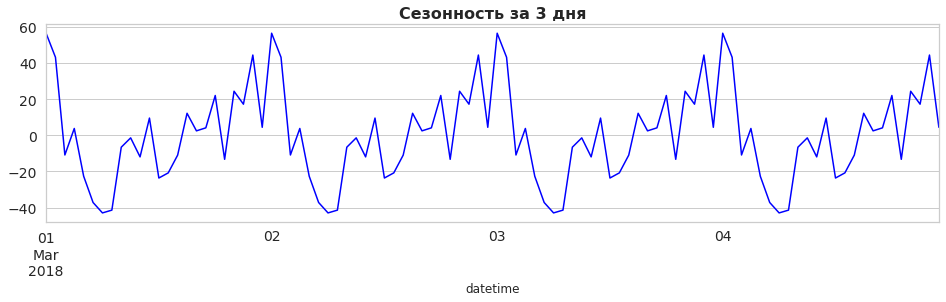

In [16]:
# кол-во дней
n = 3
for i in range(2, n + 2, 1):
    plt.figure(figsize=(16,8))
    decomposed_day = seasonal_decompose(df['2018-03-01':f'2018-03-0{i}'])
    plt.subplot(211)
    decomposed_day.seasonal.plot(ax=plt.gca(), color='blue', fontsize=14)
    plt.title(f'Сезонность за {i - 1} дня', fontsize=16, fontweight='bold')
    plt.show()

**Вывод:** Пиковая нагрузка приходится на полуночь (00:00), а до примерно 06:00 имеется тенденция к спаду (и так по циклу)

Рассмотрим месячную сезонность:

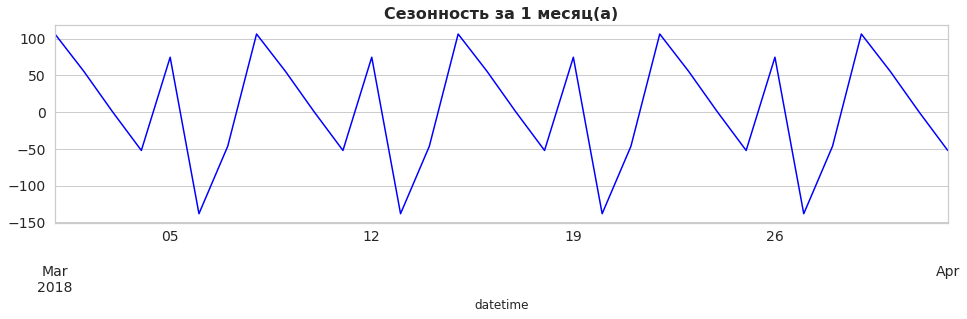

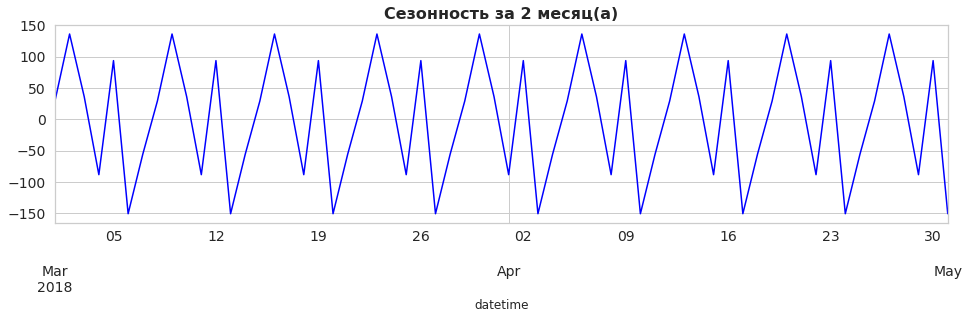

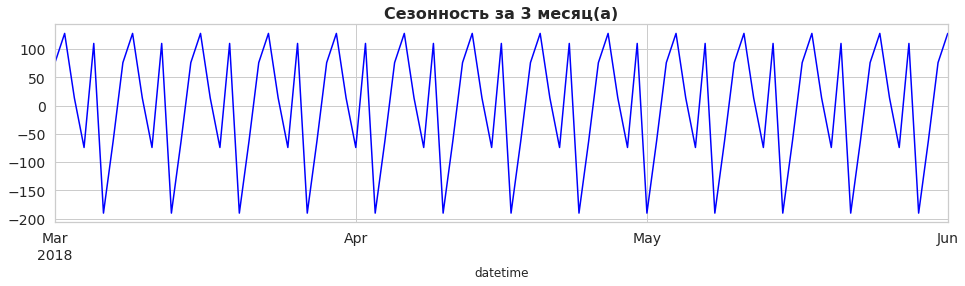

In [17]:
# кол-во месяцев
n = 3
for i in range(4, n + 4, 1):
    plt.figure(figsize=(16,8))
    decomposed_day = seasonal_decompose(df['2018-03-01':f'2018-0{i}-01'].resample('1D').sum())
    plt.subplot(211)
    decomposed_day.seasonal.plot(ax=plt.gca(), color='blue', fontsize=14)
    plt.title(f'Сезонность за {i - 3} месяц(а)', fontsize=16, fontweight='bold')
    plt.show()

Теперь можно сказать - максимальная загрузка в понедельник( номер 0), минимальная загрузка - суббота( номер 06), очен хороший спрос в пятницу( номер 05)

Определили дневную сезонность - максимальная загрузка в понедельник, минимальная загрузка - суббота, очен хороший спрос в пятницу. Определили суточную сезонность - максимальная загрузка в районе 00:00, спад до ~06:00 (минимальная загрузка), с дальнейшем не плавным ростом до 00:00.
Про месячную сезонность - нельзя ничего говорить, данные не за полный год.
Определили тренд - рост с каждым месяцем. Но данные не полные, рост может быть связан с временем года.

Шаг прогнозирования небольшой - примем все вышеуказанное как факт

## Обучение

In [18]:
def rmse(true, pred):
    return np.sqrt(mean_squared_error(true, pred))

In [19]:
def make_features(df, max_lag, rolling_mean_size):
    df['hour'] = df.index.hour    
    df['day_of_week'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
        
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

**Модель линейной регрессии:**

In [20]:
%%time

best_rmse = 1000

for max_lag in range(5, 201, 5):
    for rolling_mean_size in range(10, 101, 10):
        
        df_changed = make_features(df, max_lag, rolling_mean_size)
        df_changed = df_changed.dropna()
        features = df_changed.drop('num_orders', axis=1)
        target = df_changed['num_orders']
        features_train, features_, target_train, target_ = \
train_test_split(features, target, test_size=.2, shuffle=False)
        features_valid, features_test, target_valid, target_test = \
        train_test_split(features_, target_, test_size=.5, shuffle=False)
        
        model = LinearRegression()
        
        model.fit(features_train, target_train)
        lin_rmse = rmse(target_valid, model.predict(features_valid))
        
        if lin_rmse < best_rmse:
            best_rmse = lin_rmse
            best_linear_model = model
            best_lag = max_lag
            best_rolling_mean_size = rolling_mean_size
            best_df = df_changed
            
print('Наилучший RMSE линейной модели на валидационной выборке составил {:.1f}'.format(best_rmse))
print('Оптимальное количество столбцов с отстающими значениями:', best_lag)
print('Оптимальный размер скользящего окна:', best_rolling_mean_size)

Наилучший RMSE линейной модели на валидационной выборке составил 29.0
Оптимальное количество столбцов с отстающими значениями: 195
Оптимальный размер скользящего окна: 50
CPU times: user 1min 20s, sys: 1min 12s, total: 2min 33s
Wall time: 2min 35s


**Модель случайного леса:**

In [21]:
df = best_df

features = df.drop('num_orders', axis=1)
target = df['num_orders']

features_train, features_, target_train, target_ =  \
train_test_split(features, target, test_size=.2, shuffle=False)

features_valid, features_test, \
target_valid, target_test = train_test_split(features_, target_, test_size=.5, shuffle=False)

In [22]:
%%time

best_forest_rmse = 1000
for n_estimators in [10, 50, 100]:
    for max_depth in [1, 10, 20]:
        
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=1)
        
        model.fit(features_train, target_train)
        rmse_valid = rmse(target_valid, model.predict(features_valid))
        
        if rmse_valid < best_forest_rmse:
            best_forest_rmse = rmse_valid
            best_forest_model = model
            best_forest_estimators = n_estimators
            best_forest_depth = max_depth
            
print('Лучший результат на валидационной выборке составил {:.1f}'.format(best_forest_rmse))
print(f'Оптимальные гиперпараметры модели: {best_forest_estimators} деревьев при глубине {best_forest_depth}')

Лучший результат на валидационной выборке составил 30.0
Оптимальные гиперпараметры модели: 50 деревьев при глубине 20
CPU times: user 1min 26s, sys: 1.03 s, total: 1min 27s
Wall time: 1min 27s


In [24]:
print('RMSE модели RandomForestRegressor на валидационной выборке составил {:.1f}'.format(best_forest_rmse))

RMSE модели RandomForestRegressor на валидационной выборке составил 30.0


**CatBoost**

In [25]:
%%time

model_cb = CatBoostRegressor(loss_function='RMSE', random_seed=1, iterations=150, 
                             learning_rate=0.03, depth=10, use_best_model=True, eval_metric='RMSE')
model_cb.fit(features_train, target_train,
          eval_set=(features_train, target_train),
          verbose=False)

CPU times: user 52.4 s, sys: 362 ms, total: 52.8 s
Wall time: 53.7 s


In [26]:
train_rmse_cb = rmse(target_valid, model_cb.predict(features_valid))
print('RMSE модели CatBoost на валидационной выборке составил {:.1f}'.format(train_rmse_cb))

RMSE модели CatBoost на валидационной выборке составил 32.2


**XGBoost**

In [27]:
%%time
model_xgb = XGBRegressor(learning_rate=0.03, n_estimators=200, seed=1, max_depth=15)
model_xgb.fit(features_train, target_train)

CPU times: user 7min 28s, sys: 0 ns, total: 7min 28s
Wall time: 7min 35s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.03, max_delta_step=0,
             max_depth=15, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=1, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [28]:
train_rmse_xgb = rmse(target_valid, model_xgb.predict(features_valid))
print('RMSE модели XGBoost на тренировочной выборке составил {:.1f}'.format(train_rmse_xgb))

RMSE модели XGBoost на тренировочной выборке составил 32.5


In [29]:
results = pd.DataFrame({'Models':['LinearRegression', 'RandomForestRegressor', 'CatBoost', 'XGBoost'],
                        'RMSE': [best_rmse, best_forest_rmse, train_rmse_cb, train_rmse_xgb]})

results

,Models,RMSE
0,LinearRegression,28.955884
1,RandomForestRegressor,30.047808
2,CatBoost,32.210563
3,XGBoost,32.524306


**Вывод:** Наилучший результат показала модель линейной регрессии. На ней и будем проверять тестовый RMSE

## Тестирование

In [33]:
%%time
        
df_changed = make_features(df, best_lag, best_rolling_mean_size)
df_changed = df_changed.dropna()
features = df_changed.drop('num_orders', axis=1)
target = df_changed['num_orders']
features_train, features_, target_train, target_ = \
train_test_split(features, target, test_size=.2, shuffle=False)
features_valid, features_test, target_valid, target_test = \
train_test_split(features_, target_, test_size=.5, shuffle=False)

model = LinearRegression()

model.fit(features_train, target_train)
lin_rmse = rmse(target_test, model.predict(features_test))

            
print('Наилучший RMSE линейной модели на валидационной выборке составил {:.1f}'.format(lin_rmse))

Наилучший RMSE линейной модели на валидационной выборке составил 34.2
CPU times: user 437 ms, sys: 0 ns, total: 437 ms
Wall time: 460 ms


<AxesSubplot:title={'center':'Сравнение реальных значений и предсказаний на тестовой выборке'}, xlabel='datetime'>

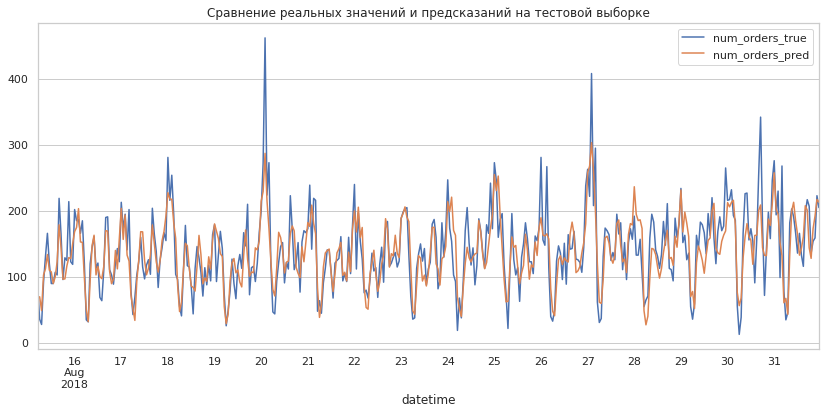

In [34]:
lin_res = pd.DataFrame({'num_orders_true':target_test,
                        'num_orders_pred':model.predict(features_test)})
lin_res.plot(figsize=(14,6), title='Сравнение реальных значений и предсказаний на тестовой выборке')

**Вывод:** На модели линейной регрессии получен RMSE = 34.2 < 48. На графике видно, что модель достаточно точно предсказала значения.